In [1]:
from collections import Counter
from itertools import chain
import json
import os
import os.path as path
import random
import re
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import string

import fasttext
import spacy
from nltk.corpus import stopwords

from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser, Phrases, ENGLISH_CONNECTOR_WORDS

In [2]:
# directories and constants
data_dir = "../data"
selfparsed_dir = path.join(data_dir, "selfparsed")
GROUPS = ['other', 'sustainability']

## NLP preparation

In [4]:
# FastText language detector
language_detector = fasttext.load_model("../models/fasttext-lid.176.bin")

# define allowed POS, stopwords, and replacers
ALLOWED_POS = set(["ADJ", "ADV", "NOUN", "PROPN", "VERB"]) # check this 
STOPWORDS = set(stopwords.words("english"))
REPLACER_TABLE = str.maketrans('', '', string.punctuation + string.digits)

# load company aliases (to remove from text)
with open(path.join(data_dir, "company-aliases.txt"), 'r') as f:
    ALIASES = set(f.read().splitlines())

# SpaCy tokenizer and POS tagger
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
nlp.add_pipe('sentencizer')

## Functions

In [5]:
# company aliases generator
def create_aliases(company):
    # return set of possible alternative names of the input company name
    
    # remove common unimportant components
    no_period = re.sub("\.", "", company)
    no_suffix = re.sub("\s(ag|sa|ch|pte|ltd)\s", " ", no_period, flags=re.I)
    no_groups = re.sub("(gruppe|group|holding|international)", "", no_suffix, flags=re.I)

    # remove anything in brackets, e.g. 'Tetra Pak (Schweiz)' -> 'Tetra Pak'
    no_brackets = re.sub("\(.*?\)", "", no_groups)
    no_brackets = re.sub("\s{2,}", " ", no_brackets) # strip whitespace

    # replace hyphens by space, e.g. 'u-blox' -> 'u blox'
    no_hyphens = re.sub("-", " ", no_groups)
    no_hyphens = re.sub("\s{2,}", " ", no_hyphens) # strip whitespace

    # assume any entirely uppercase token is an acronym, e.g. SBB
    acronyms = [tok for tok in no_groups.split() if tok.isupper()]
    acronyms = [re.sub("\(|\)", "", tok) for tok in acronyms] # strip brackets
    
    # skip aliases that are extremely short
    aliases = acronyms + [company, no_suffix, no_brackets, no_hyphens]
    aliases = set([_.strip() for _ in aliases if len(_.strip()) > 1])
    return list(aliases)

In [12]:
# text file reader
def read_texts(dir):
    filenames = [_ for _ in os.listdir(dir) if _.endswith(".txt")]
    for filename in filenames:
        filepath = path.join(dir, filename)
        with open(filepath, 'r') as f:
            text = "".join(f.readlines())
            if len(text) < 50:
                print(f"WARNING: {filepath} has <50 characters")
                continue
            yield {'filename': filename, 'text': text}

In [6]:
# language detector
def detect_language(text, language_detector):
    text = text.replace("\n", " ")
    language = language_detector.predict(text)[0][0]
    return language

In [7]:
# preprocessing functions
def remove_aliases(text, aliases=ALIASES):
    # remove all occurrences of any company aliases
    # regex: https://stackoverflow.com/questions/6116978/how-to-replace-multiple-substrings-of-a-string

    rep = {alias: "" for alias in aliases}
    rep = dict((re.escape(k), v) for k, v in rep.items()) 
    pattern = re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[re.escape(m.group(0))], text)
    return text

def clean(
    token, min_length=3, replacer_table=REPLACER_TABLE, 
    allowed_pos=ALLOWED_POS, stopwords=STOPWORDS):
    # returns lemmatized, lowercased form of token

    lemma = token.lemma_.lower().strip()

    # replace any character in replacer_table by emptystring
    lemma = lemma.translate(replacer_table)

    # return emptystring for stopwords and tokens without allowed POS
    if len(lemma) < min_length or token.pos_ not in allowed_pos or lemma in stopwords:
        return ""
    else:
        return lemma


def preprocess(text, nlp_model, min_token_length=3, aliases=ALIASES):
    # returns text as a list of cleaned, tokenized paragraphs
    
    text = remove_aliases(text, aliases)
    paragraphs = [para.replace("\n", " ") for para in text.split("\n\n")]

    tokenized_doc = []
    for para in nlp_model.pipe(paragraphs):
        # tokenize para and skip empty tokens
        tokenized_para = [
            clean(token, min_length=min_token_length) for token in para]
        tokenized_para = [token for token in tokenized_para if token]

        # skip empty paras
        if tokenized_para:
            tokenized_doc.append(tokenized_para)

    return tokenized_doc

## Run functions

In [9]:
# create company aliases from given company names
# change flag to 'True' to run
if False:
    filepath = path.join(data_dir, "companies.txt")
    outpath = path.join(data_dir, "company-aliases.txt")

    with open(filepath, 'r') as f, open(outpath, 'w') as f_out:
        for company in f:
            for alias in create_aliases(company):
                print(alias, file=f_out)

In [13]:
# preprocess all english documents from each group and export
# change flag to True to run
if True:
    for group in GROUPS:
        # prepare output file
        outpath = path.join(
            selfparsed_dir, f"preprocessed-english-{group}-noaliases.jsonl")
        f_out = open(outpath, 'w')

        group_dir = path.join(selfparsed_dir, group)
        for x in tqdm(read_texts(group_dir)):

            # skip non-english texts
            language = detect_language(x['text'], language_detector)
            if language != "__label__en":
                continue

            x['preprocessed'] = preprocess(x['text'], nlp) # preprocess text
            print(json.dumps(x), file=f_out) # export

        f_out.close()

121it [03:06,  1.54s/it]
29it [00:25,  1.26it/s]

134it [01:51,  1.21it/s]


## Data Exploration

In [14]:
# load data
data = {group: [] for group in GROUPS}
for group, group_data in data.items():
    filepath = path.join(selfparsed_dir, f"preprocessed-english-{group}-noaliases.jsonl")

    with open(filepath, 'r') as f:
        for line in f:
            x = json.loads(line)
            group_data.append(x)

    print(f"Number of documents in {group}: {len(group_data)}")    

Number of documents in other: 79
Number of documents in sustainability: 74


In [15]:
# TODO: find reasonable and optimal requirements on paragraph lengths
# for now, set min length of 5 tokens and max length of 400 tokens
for group_data in data.values():
    for x in group_data:
        x['preprocessed'] = [
            para for para in x['preprocessed'] 
            if len(para) > 4 and len(para) < 400]

In [16]:
# peek at data
for group, group_data in data.items():
    x = group_data[0]
    print(f"\ngroup: {group}")
    print(f"sample preprocessed document:")
    for para in x['preprocessed'][:10]:
        print(f"- {' . '.join(para)}")


group: other
sample preprocessed document:
- annual . report . trafigura . group . pte
- oil . petroleum . products . revenue . percentage . group . revenue
- oil . petroleum . products . total . volume . trade
- bulk . mineral . total . volume . trade
- non . ferrous . concentrate . refined . metal . total . volume . trade
- metal . minerals . revenue . percentage . group . revenue
- traﬁgura . ﬁnancial . year . run . october . september . figure . period . include . new . ifrs . reporting . requirement . metric . tonne
- trafigura . group . pte . ltd . company . directly . indirectly . investment . separate . distinct . entity . publication . collective . expression . trafigura . trafigura . group . company . group . use . convenience . reference . make . general . company . likewise . word . use . place . refer . company . trafigura . group . general . expression . also . use . useful . purpose . serve . identify . particular . company . company
- ebitda . earning . interest . tax 

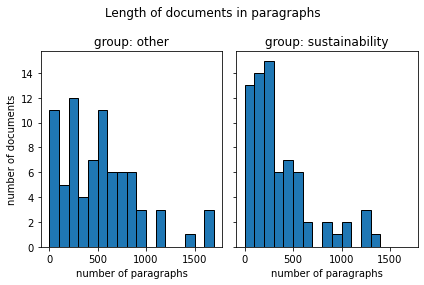

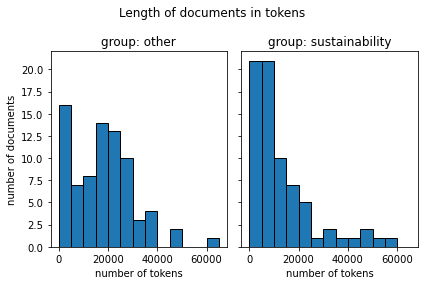

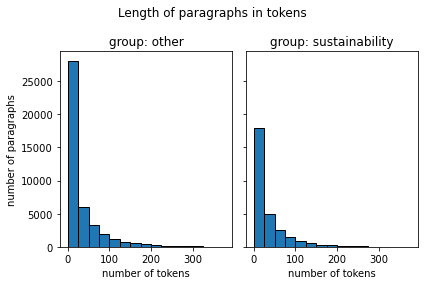

In [17]:
# length of documents and paragraphs
f, axes = plt.subplots(1, 2, sharex=True, sharey=True)
f.suptitle("Length of documents in paragraphs")
axes[0].set_ylabel("number of documents")
for i, group in enumerate(data.keys()):
    num_sents = [len(x['preprocessed']) for x in data[group]]

    axes[i].hist(
        num_sents, edgecolor='black', bins=range(0, max(num_sents), 100))
    axes[i].set_title(f"group: {group}")
    axes[i].set_xlabel("number of paragraphs")
plt.tight_layout()
plt.show()

f, axes = plt.subplots(1, 2, sharex=True, sharey=True)
f.suptitle("Length of documents in tokens")
axes[0].set_ylabel("number of documents")
for i, group in enumerate(data.keys()):
    num_tokens = [
        len(list(chain.from_iterable(x['preprocessed']))) 
        for x in data[group]]

    axes[i].hist(
        num_tokens, edgecolor='black', bins=range(0, max(num_tokens), 5000))
    axes[i].set_title(f"group: {group}")
    axes[i].set_xlabel("number of tokens")
plt.tight_layout()
plt.show()

f, axes = plt.subplots(1, 2, sharex=True, sharey=True)
f.suptitle("Length of paragraphs in tokens")
axes[0].set_ylabel("number of paragraphs")
for i, group in enumerate(data.keys()):
    para_lengths = [
        len(para) for x in data[group] for para in x['preprocessed']]

    axes[i].hist(
        para_lengths, edgecolor='black', bins=range(0, max(para_lengths), 25))
    axes[i].set_title(f"group: {group}")
    axes[i].set_xlabel("number of tokens")
plt.tight_layout()
plt.show()

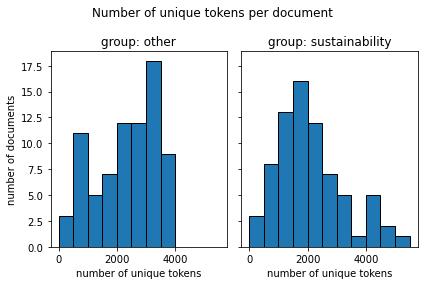

In [18]:
# size of document-wise vocabularies
f, axes = plt.subplots(1, 2, sharex=True, sharey=True)
f.suptitle("Number of unique tokens per document")
axes[0].set_ylabel("number of documents")

vocabulary = {}
for i, group in enumerate(data.keys()):
    group_vocabs = []
    for x in data[group]:
        tokens = [tok for para in x['preprocessed'] for tok in para]
        group_vocabs.append(Counter(tokens))
    vocabulary[group] = group_vocabs
    
    vocab_lengths = [len(v) for v in group_vocabs]
    axes[i].hist(
        vocab_lengths, edgecolor='black', 
        bins=range(0, max(vocab_lengths), 500))
    axes[i].set_title(f"group: {group}")
    axes[i].set_xlabel("number of unique tokens")
    
plt.tight_layout()
plt.show()

Number of unique tokens in other: 27405
Number of unique tokens in sustainability: 26020


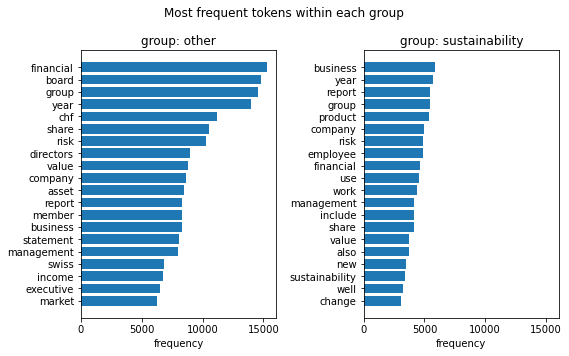

In [19]:
# current number of unique tokens in all documents
total_vocabulary = {}
for group, group_vocabs in vocabulary.items():
    total_group_vocab = Counter()
    for v in group_vocabs:
        total_group_vocab.update(v)
    total_vocabulary[group] = total_group_vocab

for group, total_group_vocab in total_vocabulary.items():
    print(f"Number of unique tokens in {group}: {len(total_group_vocab)}")

# most frequent tokens per group
f, axes = plt.subplots(1, 2, figsize=(8, 5), sharex=True)
for i, group in enumerate(total_vocabulary.keys()):
    tokens, freq = zip(*total_vocabulary[group].most_common(20)[::-1])
    axes[i].barh(tokens, freq)
    
    axes[i].set_title(f"group: {group}")
    axes[i].set_xlabel("frequency")

f.suptitle("Most frequent tokens within each group")
plt.tight_layout()
plt.show()

In [14]:
# how many tokens appear only rarely?
min_freq = 10
for group, total_group_vocab in total_vocabulary.items():
    rare_tokens = [
        tok for tok, freq in total_group_vocab.items() if freq < min_freq
    ]

    print(f"group: {group}")
    print(f"Number of tokens with freq < {min_freq}: {len(rare_tokens)}")
    print(f"Examples: {rare_tokens[:5]}\n")

group: other
Number of tokens with freq < 10: 20709
Examples: ['stories', 'customizing', 'prefabrication', 'refurbish', 'microelectronic']

group: sustainability
Number of tokens with freq < 10: 20067
Examples: ['porto', 'sudeste', 'deconsolidate', 'midland', 'texas']



In [20]:
# peek at dictionary after constructing bigrams and filtering extremes
dictionary = {}
for group, group_data in data.items():
    print(f"\ngroup: {group}")
    group_texts = [
        list(chain.from_iterable(x['preprocessed'])) for x in group_data]

    # create bigrams from input texts (default hyperparameters)
    phrases = Phrases(group_texts, connector_words=ENGLISH_CONNECTOR_WORDS)
    bigram_phraser = Phraser(phrases)
    group_texts = [bigram_phraser[text] for text in group_texts]

    # create dictionary and filter extremes
    group_dictionary = Dictionary(group_texts)
    print(f"Size of original dictionary: {len(group_dictionary)}")

    group_dictionary.filter_extremes(no_below=5, no_above=0.5)
    print(f"Size of filtered dictionary: {len(group_dictionary)}")

    print("Most common words in dictionary")
    print(group_dictionary.most_common(5))

    dictionary[group] = group_dictionary


group: other
Size of original dictionary: 35187
Size of filtered dictionary: 9421
Most common words in dictionary
[('swiss_post', 2115), ('recognize', 1232), ('postfinance', 817), ('franc', 798), ('client', 787)]

group: sustainability
Size of original dictionary: 33179
Size of filtered dictionary: 8178
Most common words in dictionary
[('pmi', 1416), ('client', 1164), ('compensation', 1100), ('bank', 1034), ('und', 769)]
